# 線形歪による影響を見る
非線形歪は加えない

In [20]:
#import
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

sys.path.append('../')
from pyopt.util import fft, ifft
from pyopt import modulate as md

# 1. 線形歪計算用class

In [1]:
class Signal:
    def __init__(self, seq, form='RZ16QAM', n=32, baudrate=28, PdBm=0.0, Ledfa=100, stepedfa=30, D=16, Alpha=0.16):
        self.seq = seq
        self.form = form
        self.n = n
        self.baudrate = baudrate
        self.PdBm = PdBm
        self.Ledfa = Ledfa
        self.stepedfa = stepedfa
        self.D = D
        self.Alpha = Alpha

        """固定パラメータ"""
        self.bitratelist = {'NRZQPSK': self.baudrate * 2,
                            'RZQPSK': self.baudrate * 2,
                            'NRZ16QAM': self.baudrate * 4,
                            'RZ16QAM': self.baudrate * 4}
        self.bitrate = self.bitratelist[self.form]  # ビットレート[Gbps]
        self.B = self.baudrate * 2 * 10 ** 9  # 帯域幅[bit/s]
        self.c = 3 * 10 ** 5  # ファイバ中光速[km/sec]
        self.Lambda_c = 1550  # キャリア波長[nm]
        self.f_c = self.c * 10 ** 3 / (self.Lambda_c * 10 ** -9)  # キャリア周波数[Hz]
        self.Omega_c = 2 * np.pi * self.c * 10 ** 3 / self.Lambda_c  # キャリア光角周波数[G rad/s]
        self.nc = 1.46  # コア屈折率
        self.a = 5 * 10 ** -6  # コア半径[m]
        self.As = np.pi * self.a ** 2  # コア面積[m^2]
        self.Xi = 1.5  # コア面積補正
        self.B2 = (-self.D * self.Lambda_c ** 2 * 10 ** -6) / (2 * np.pi * self.c)  # 2次分散[ns^2/km]
        self.G = 10 ** (self.Alpha * self.Ledfa / 10)  # EDFA利得

        """初期信号"""
        self.PW = 10 ** (self.PdBm / 10 - 3)  # 光電力[W]
        self.Phi_p = np.sqrt((120 * np.pi / self.nc) * self.PW / (self.Xi * self.As))  # 光電界強度[V/m]
        self.signal = {'Lnow': 0, 'x_Lnow': self.Phi_p * self.seq}
        self.signal['x_0'] = self.signal['x_Lnow']

        """軸生成"""
        self.length = len(self.signal['x_Lnow'])
        self.Frequency = self._frequency()  # 周波数軸[GHz]
        self.Lambda = self._wavelength()  # 波長軸[nm]
        self.Omega = self._omegafrequency() * 10 ** -9  # 光角周波数軸[G rad]

    def _timeslot(self):  # Ts[ps/bit] bitあたりの時間長
        Ts = 1 / (self.bitrate * 10 ** 9) * 10 ** 12
        return Ts

    def _frequency(self):  # Lambda_c[nm] 中心波長 Speed[Gb/s]
        Ts = self._timeslot()  # Ts[ps] 1タイムスロット(n点)の時間
        dt = Ts / self.n  # dt[ps] 1点の時間
        fc = 3 * 10 ** 8 / (self.Lambda_c * 10 ** -9) * 10 ** -9  # fc[GHz]
        df = 1 / (dt * (10 ** -12) * self.length) * 10 ** -9  # df[GHz]
        fwidth = 1 / (2 * dt) * 10 ** 3
        Frequency = np.zeros(self.length, dtype=float)
        for i in range(self.length):
            Frequency[i] = fc + (fwidth - df * i)  # f[GHz]
        return Frequency

    def _wavelength(self):  # Lambda_c[nm] 中心波長 Speed[Gb/s]
        fr = self._frequency()  # f[GHz] 周波数軸
        Lambda = 3 * 10 ** 8 / (fr * 10 ** 9) * 10 ** 9  # Lambda[nm] 波長軸
        return Lambda

    def _omegafrequency(self):  # Lambda_c[nm] 中心波長 Speed[Gb/s]
        fr = self._frequency()  # f[GHz] 周波数軸
        Omega = 2 * np.pi * fr * 10 ** 9  # Omega[rad] 角周波数軸
        return Omega

    def cal_evm(self, L, signal):
        input_signal = self.signal['x_0'][int(self.n / 2):: self.n]
        tmp = 0
        for i in range(len(signal)):
            tmp += abs(signal[i] - input_signal[i]) ** 2 / abs(input_signal[i]) ** 2
        evm = np.sqrt(tmp / len(signal)) * 100
        return evm

    def cal_evm_min(self, L, signal):
        input_signal = self.signal['x_0'][int(self.n / 2):: self.n]
        evm_min = 200
        i_min = 0
        for i in range(360):
            signal = signal * np.exp(1j * i * np.pi/180)
            tmp = 0
            for j in range(len(signal)):
                tmp += abs(signal[j] - input_signal[j]) ** 2 / abs(input_signal[j]) ** 2
            evm = np.sqrt(tmp / len(signal)) * 100
            if evm < evm_min:
                evm_min = evm
                i_min = i
        return evm_min, i_min

    def cal_ber(self, L, signal):
        evm = self.cal_evm(L, signal)
        M = {'NRZQPSK': 4,
             'RZQPSK': 4,
             'NRZ16QAM': 16,
             'RZ16QAM': 16}
        ber = (1 - M[self.form] ** (-1 / 2)) / (1 / 2 * np.log2(M[self.form])) \
            * special.erfc(np.sqrt(3 / 2 / (M[self.form] - 1) / (evm / 100) ** 2))
        return ber

    def cal_qfac(self, L, signal):
        ber = self.cal_ber(L, signal)
        q = 20 * np.log10(np.sqrt(2) * special.erfcinv(2 * ber))
        return q

    def cal_snr(self, L, signal):
        evm = self.cal_evm(L, signal)
        snr = 10 * np.log10(1 / (evm / 100) ** 2)
        return snr

    def transmission(self, Lmax=1000):
        for _ in tqdm(range(int((Lmax - self.signal['Lnow']) / self.Ledfa))):
            self.transmission_1span(ase)

    def transmission_1span(self):
        tmp = self.signal['x_Lnow']
        tmp = self._add_dispersion(tmp)  # 線形歪,減衰を同時に加える
        tmp *= 10 ** (self.Alpha * self.Ledfa / 10)  # EDFAによる増幅を行う
        self.signal['x_Lnow'] = tmp
        self.signal['Lnow'] += self.Ledfa
        if self.signal['Lnow'] % 500 == 0:
            self.signal['x_'+str(self.signal['Lnow'])] = tmp

    def linear_compensation(self, L, x):
        S = fft(x)
        S /= self._H(L)
        x = ifft(S)
        return x

    def _H(self, L):  # H ファイバの伝達関数
        out = np.exp(-1j * self.B2 * L / 2 * (self.Omega - self.Omega_c) ** 2)
        return out

    def _add_dispersion(self, x):
        dL = self.Ledfa / self.stepedfa  # dL[km] 区間一つの長さ
        dH = self._H(dL / 2)  # dH 区間一つの半分における伝達関数
        ddL = dL * 10 ** 3  # ddL[m]

        for i in range(self.stepedfa):
            """1区間の前半の周波数領域での線形歪を計算"""
            X = fft(x)
            X = X * dH
            x = ifft(X)

            """伝搬損失の計算"""
            x = x * 10 ** (-self.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100

            """1区間の後半の周波数領域での線形歪を計算"""
            X = fft(x)
            X = X * dH
            x = ifft(X)

            """伝搬損失の計算"""
            x = x * 10 ** (-self.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100
        return x

# 1.2 復調信号生成

In [2]:
N = 13  # PRBSの次数
itr = 1  # PRBSの繰り返し回数

In [8]:
bitsq = md.prbs(N=N, itr=itr)

print('ビット列: ', bitsq[:128])
print('ビット長: ', bitsq.shape)

ビット列:  [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0
 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1]
ビット長:  (8192,)


In [9]:
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか

In [10]:
mdl = md.Modulate(form=form, n=n, equalize=equalize)
modsq = mdl.transform(bitsq)

print('シンボル列: ', modsq[:40])
print('シンボル長: ', modsq.shape)  # 128 / 4 * 32 = 1024

rz16QAM modulation START
シンボル列:  [0.        +0.j         0.0438346 -0.0438346j  0.08724704-0.08724704j
 0.12981925-0.12981925j 0.17114123-0.17114123j 0.21081503-0.21081503j
 0.24845856-0.24845856j 0.2837093 -0.2837093j  0.31622777-0.31622777j
 0.34570078-0.34570078j 0.37184451-0.37184451j 0.39440718-0.39440718j
 0.41317149-0.41317149j 0.42795673-0.42795673j 0.43862051-0.43862051j
 0.44506014-0.44506014j 0.4472136 -0.4472136j  0.44506014-0.44506014j
 0.43862051-0.43862051j 0.42795673-0.42795673j 0.41317149-0.41317149j
 0.39440718-0.39440718j 0.37184451-0.37184451j 0.34570078-0.34570078j
 0.31622777-0.31622777j 0.2837093 -0.2837093j  0.24845856-0.24845856j
 0.21081503-0.21081503j 0.17114123-0.17114123j 0.12981925-0.12981925j
 0.08724704-0.08724704j 0.0438346 -0.0438346j  0.        +0.j
 0.0438346 -0.0438346j  0.08724704-0.08724704j 0.12981925-0.12981925j
 0.17114123-0.17114123j 0.21081503-0.21081503j 0.24845856-0.24845856j
 0.2837093 -0.2837093j ]
シンボル長:  (65536,)


# 1.3 線形歪付加

In [18]:
sgnl = Signal(seq=modsq, form='RZ16QAM', n=32, baudrate=28, PdBm=1.0, Ledfa=100, stepedfa=30, D=16, Alpha=0.16)
sgnl.transmission(Lmax=2500)

# 1.4 可視化

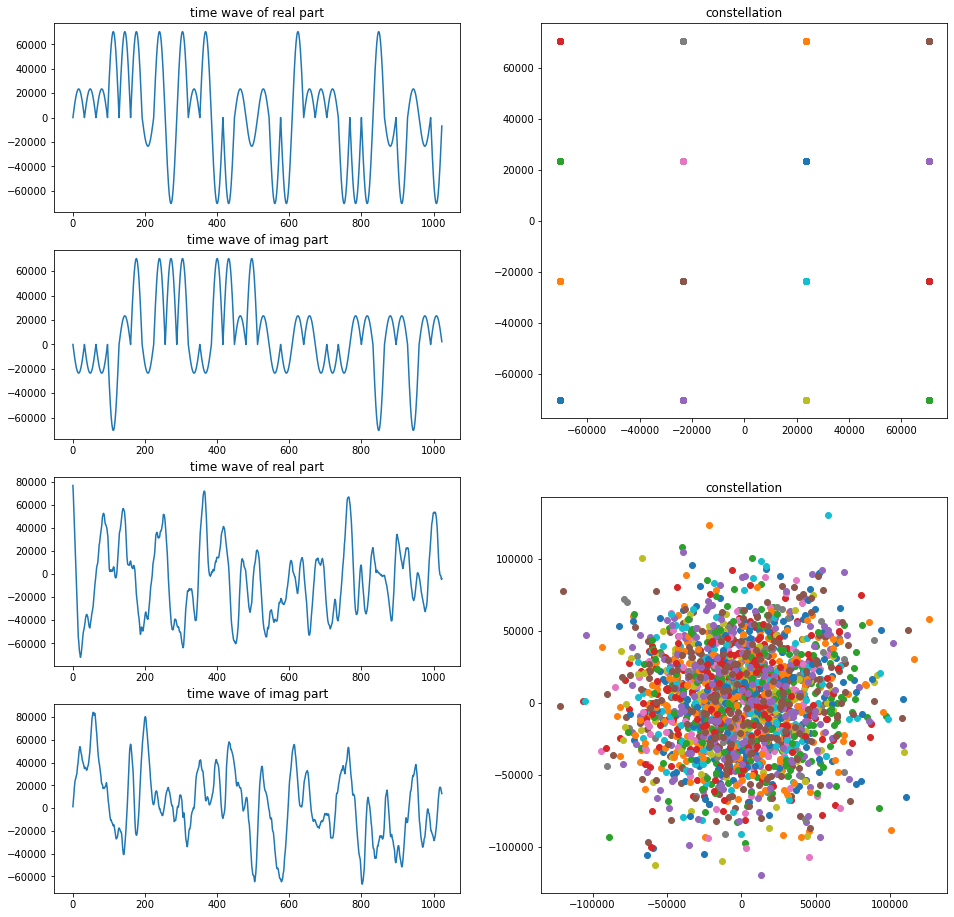

In [38]:
seq = sgnl.seq[int(n/2):: n]
symbol = np.unique(seq)
sgnl_in = sgnl.signal['x_0']
sgnl_dispersion = sgnl.signal['x_500']
#sgnl_dispersion = sgnl.linear_compensation(500, sgnl_dispersion)

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(4, 2, 5)
ax5 = fig.add_subplot(4, 2, 7)
ax6 = fig.add_subplot(2, 2, 4)

ax1.plot(sgnl_in[:32 * n].real)
ax1.set_title('time wave of real part')
ax2.plot(sgnl_in[:32 * n].imag)
ax2.set_title('time wave of imag part')
for i in range(len(symbol)):
    ax3.plot(sgnl_in[int(n/2):: n][seq == symbol[i]].real, sgnl_in[int(n/2):: n][seq == symbol[i]].imag, 'o')
ax3.set_title('constellation')

ax4.plot(sgnl_dispersion[:32 * n].real)
ax4.set_title('time wave of real part')
ax5.plot(sgnl_dispersion[:32 * n].imag)
ax5.set_title('time wave of imag part')
for i in range(len(symbol)):
    ax6.plot(sgnl_dispersion[int(n/2):: n][seq == symbol[i]].real, sgnl_dispersion[int(n/2):: n][seq == symbol[i]].imag, 'o')
ax6.set_title('constellation');

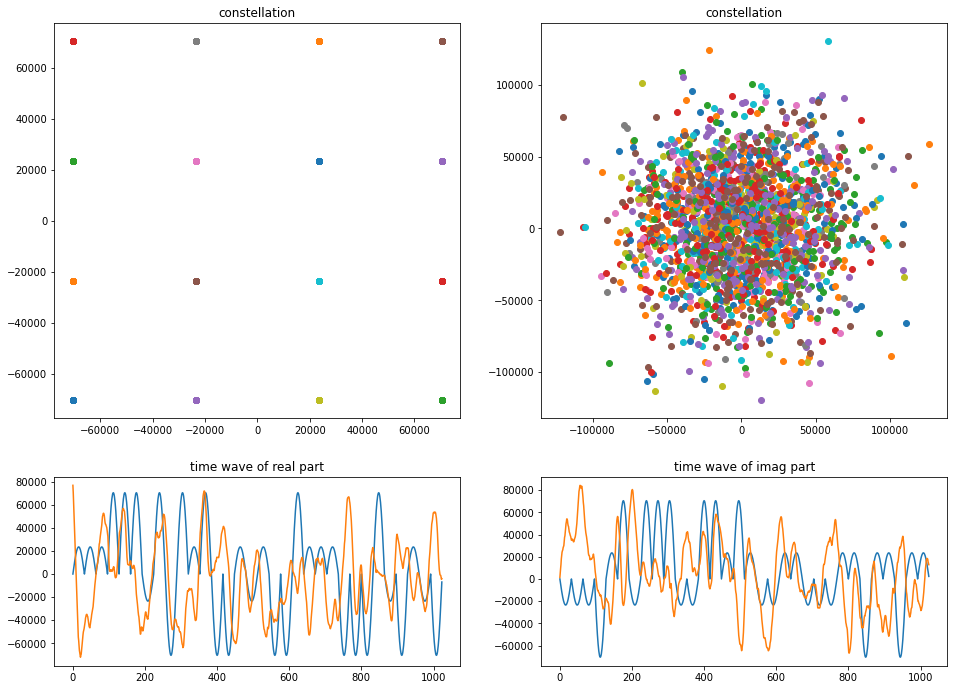

In [39]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(4, 2, 5)
ax4 = fig.add_subplot(4, 2, 6)

for i in range(len(symbol)):
    ax1.plot(sgnl_in[int(n/2):: n][seq == symbol[i]].real, sgnl_in[int(n/2):: n][seq == symbol[i]].imag, 'o')
ax1.set_title('constellation')

for i in range(len(symbol)):
    ax2.plot(sgnl_dispersion[int(n/2):: n][seq == symbol[i]].real, sgnl_dispersion[int(n/2):: n][seq == symbol[i]].imag, 'o')
ax2.set_title('constellation')

ax3.plot(sgnl_in[:32 * n].real)
ax3.plot(sgnl_dispersion[:32 * n].real)
ax3.set_title('time wave of real part')

ax4.plot(sgnl_in[:32 * n].imag)
ax4.plot(sgnl_dispersion[:32 * n].imag)
ax4.set_title('time wave of imag part');